# Market selection by using portfolio theory

In [541]:

import os,sys,matplotlib,pandas,numpy,scipy,dateutil
import pandas as pd
import numpy as np
from pylab import *
from datetime import datetime, timedelta
import time
from statsmodels.distributions.empirical_distribution import ECDF
import sqlite3
import itertools, random
import pickle
conn = None
use_database = False

## Reading price data.
Markets (also called instances in some parts of the code) are represented as dictionaries.
We define functions for converting them to appropriate database strings if required. 

In [542]:
markets = [ {'type': 'g2.2xlarge', 'region': 'us-east-1', 'AZ': 'a', 'OS': 'Linux'} ,
                     {'type': 'c3.xlarge', 'region': 'us-east-1', 'AZ': 'a', 'OS': 'Linux'} ,
                     {'type': 'r3.large', 'region': 'us-east-1', 'AZ': 'a', 'OS': 'Linux'} ,
                     {'type': 'm3.medium', 'region': 'us-east-1', 'AZ': 'a', 'OS': 'Linux'} ,
                     {'type': 'd2.8xlarge', 'region': 'us-east-1', 'AZ': 'a', 'OS': 'Linux'} ,
            {'type': 'g2.2xlarge', 'region': 'us-east-1', 'AZ': 'b', 'OS': 'Linux'} ,
                     {'type': 'c3.xlarge', 'region': 'us-east-1', 'AZ': 'b', 'OS': 'Linux'} ,
                     {'type': 'r3.large', 'region': 'us-east-1', 'AZ': 'b', 'OS': 'Linux'} ,
                     {'type': 'm3.medium', 'region': 'us-east-1', 'AZ': 'b', 'OS': 'Linux'} ,
                     {'type': 'd2.8xlarge', 'region': 'us-east-1', 'AZ': 'b', 'OS': 'Linux'},
            {'type': 'g2.2xlarge', 'region': 'us-east-1', 'AZ': 'e', 'OS': 'Linux'} ,
                     {'type': 'c3.xlarge', 'region': 'us-east-1', 'AZ': 'e', 'OS': 'Linux'} ,
                     {'type': 'r3.large', 'region': 'us-east-1', 'AZ': 'e', 'OS': 'Linux'} ,
                     {'type': 'm3.medium', 'region': 'us-east-1', 'AZ': 'e', 'OS': 'Linux'} ,
                     {'type': 'd2.8xlarge', 'region': 'us-east-1', 'AZ': 'e', 'OS': 'Linux'}
           
                     ]

In [543]:
def instance_to_MarketId(i) :
    """ The database table names or the file names  """
    osname = {'Linux':'Linux/UNIX'}
    return i['region']+i['AZ']+'-'+osname[i['OS']]+'-'+i['type']

def instance_to_ondemstring(i) :
    """ On-demand prices table uses slightly different names for instances, aargh.
        us-east-1-Linux-c3.xlarge 
    """
    ondem_mktstring =  i['region']+'-'+ i['OS']+'-'+i['type']
    return ondem_mktstring

def instance_string(i):
    return i['region']+i['AZ']+'-'+ i['OS']+'-'+i['type']

In [544]:
#Test the instance string functions
str(instance_string(markets[0]))

'us-east-1a-Linux-g2.2xlarge'

In [545]:
def init_db_connection() :
    global conn
    global use_database
    if use_database:
        conn = sqlite3.connect('/home/prateeks/spot_prices_2015/aws.db')
    return 

init_db_connection();


In [546]:
def read_data_sqlite(instance , mktstring=None, months=['201503','201504','201505','201506','201507','201508'],pickle_data=True):
    """ Get the spot AND on-demand prices for a given instance over the months specified. 
        These 6 months are chosen to maximixe the data density, since other months have larger periods of missing data
    """
    global conn
    table_name_base='AKIAJXNAQH5WHJFPNCXA_' # '201503'
    if mktstring == None:
        mktstring = instance_to_MarketId(instance)
    output=[]
    ondem=[]
    ondemtable = 'on_demand_price'
    #Need to remove avail zone from mkt string argh!
   #TODO: function for converting to the on-demand string 
    ondem_mktstring = instance_to_ondemstring(instance)

    q2 = 'SELECT SpotPrice FROM {} WHERE MarketId=\'{}\' ;'.format(ondemtable, ondem_mktstring)
    d2 = conn.execute(q2)
    ondem = d2.fetchall()
    print instance, "ONDEM PRICE ", ondem, ondem_mktstring
    
    for month in months :
        table_name = table_name_base+month
        query='SELECT Timestamp, SpotPrice FROM {} WHERE MarketId=\'{}\' ;'.format(table_name, mktstring)
        #print query
        d = conn.execute(query)
        output.extend(d.fetchall())
    if pickle_data is True :
        fname = instance_string(instance)+'.pickle'
        with open(fname, 'w') as f :
            pickle.dump((instance, output, ondem[0][0]), f)
    return output, ondem[0][0]


In [547]:
def get_spot_data(markets, from_pickle=False):
    """
    Markets is a list of market/instance objects. 
    Return [(mkt,on-demprice,[(t,spot-price)])]
    """
    global conn
    data = []
    
    if from_pickle is False:
        init_db_connection()
        #c3.xlarge seems volatile
        for i in markets :
            ts, ondem = read_data_sqlite(i)
            spot = [(time.mktime(dateutil.parser.parse(t).timetuple()), float(f)) for (t,f) in ts]
            nspot = np.array(spot)
            data.append((i, float(ondem), nspot))
    else : 
        #Read all the pickle files from the directory and call get_pickled_data
        for file in os.listdir('.'):
            if file.endswith(".pickle") :
                with open(file,'r') as f:
                    (i, ts, ondem) = get_picked_data(f)
                    spot = [(time.mktime(dateutil.parser.parse(t).timetuple()), float(f)) for (t,f) in ts]
                    nspot = np.array(spot)
                    data.append((i, float(ondem), nspot))

    return data


In [548]:
def get_picked_data(f):
    """ Get pickled data from a file instead of the database. 
        Return (instance, ts, ondem) tuple. """
    (instance, ts, ondem) = pickle.load(f)
    return (instance, ts, ondem)
    

## Data processing
After getting spot price and on-demand price data from either the pickled objects or the database, we do some post-processing of the prices.




In [549]:
data = get_spot_data(markets, from_pickle=True)

In [550]:
def get_prices_only(d, normalized=False, interpolate=False):
    """ For a given 3-tuple, return an array of prices. Strip the timestamps
    """
    ondem_price = d[1]
    spot_prices = d[2][:,1]
    if interpolate :
        spot_prices = interpolate_prices(d)
    if normalized:
        return spot_prices/ondem_price  #time, price
    else :
        return spot_prices
    
#normalized_price(data[0])

In [551]:
def interpolate_prices(d, duration='5min'):
    """ Large gaps exist in many traces. Do some interpolation to obtain a uniform trace
    """
    spot_prices = d[2][:,1]
    timestamps = d[2][:,0]
    tdindex = pd.to_datetime(timestamps, unit='s') #Unit=s makes it parse the unix timestamps
    ms = pd.Series(spot_prices, index=tdindex)
    mdf = pd.DataFrame(ms,columns=["price"])
    
    mdf = mdf.resample(duration,fill_method='pad')
    return mdf['price']

In [552]:
def bid_transform(d,interpolate=False):
    """Given a bid, execute some transformation over the prices."""
    ondem_price = d[1]
    spot_prices = d[2][:,1]
    if interpolate:
        spot_prices = interpolate_prices(d)
    
    maxprice = 10*ondem_price
    bid = ondem_price 
    spot_prices[spot_prices >= bid] = maxprice #Amplify the price spike
    spot_prices = maxprice - spot_prices  #Price => Profits transformation
    #Not sure we want to normalize this to the on-demand price? Hmm...
    #Normalizing by 10*on-demand price yields returns which are monotonically *DECREASING* with risk
    #We want increasing returns with increasing risk, so turn off the normalization
    return spot_prices
    


In [553]:
def get_transformed_prices(d, interpolate=True, transform="bid"):
    td = [] #List of transformed prices
    instances = []

    for di in d:
        if transform=="bid":
            td.append(bid_transform(di,interpolate))
        elif transform=="plain":
            td.append(get_prices_only(di,interpolate))
        instances.append(di[0])
    min_length = min([len(a) for a in td])

    return (instances, np.vstack([a[:min_length] for a in td]) )


In [554]:
(instances, dt) = get_transformed_prices(data, transform="bid")
import scipy.stats

In [555]:
scipy.stats.describe(data[2][2][:,1])

(48994,
 (0.032099999999999997, 2.1000000000000001),
 0.15087856880434339,
 0.076725969678061057,
 2.575952995737853,
 5.251621313270784)

## Portfolio construction
So far we have read in the spot prices, applied the transforms, and computed the covariance matrix. Now its time for the actual portfolio creation.


In [556]:
import cvxopt as opt
from cvxopt import blas, solvers
%matplotlib inline

In [557]:
solvers.options['show_progress'] = False

In [558]:
def rand_weights(n):
    ''' Produces n random weights that sum to 1 '''
    k = np.random.rand(n)
    return k / sum(k)

In [559]:
num_mkts = len(instances)

Now determine on which markets we want to run the portfolio analysis. By default, we do it on ALL the markets we just read data about

In [560]:
#dt=dt[3:10]
dt=dt

In [561]:
def eval_portfolio(dt):
    p = np.asmatrix(np.mean(dt,axis=1))
    w = np.asmatrix(rand_weights(dt.shape[0]))
    C = np.asmatrix(np.cov(dt))
    
    mu = w * p.T
    sigma = np.sqrt(w * C * w.T)
    print mu, sigma
    
    return mu, sigma

In [562]:
def eval_n_portfolios(dt, n_portfolios=250):
    n_portfolios = 50
    return np.column_stack([
        eval_portfolio(dt) 
        for _ in xrange(n_portfolios)
        ])


In [563]:
means, stds = eval_n_portfolios(dt)

[[ 12.91862003]] [[ 2.23847312]]
[[ 13.70150301]] [[ 2.20229041]]
[[ 10.64355215]] [[ 1.87305188]]
[[ 10.4435207]] [[ 2.12109406]]
[[ 16.18228898]] [[ 2.99122889]]
[[ 13.56730104]] [[ 2.0630679]]
[[ 6.55169314]] [[ 0.8731162]]
[[ 7.38457475]] [[ 1.01117897]]
[[ 12.82481146]] [[ 2.12164231]]
[[ 12.08778978]] [[ 1.88610992]]
[[ 17.03857602]] [[ 2.83202747]]
[[ 11.49771826]] [[ 1.84097801]]
[[ 10.75976242]] [[ 2.02860868]]
[[ 9.77125457]] [[ 1.26284049]]
[[ 8.65328814]] [[ 1.21105509]]
[[ 10.00458077]] [[ 1.49096568]]
[[ 13.1338433]] [[ 2.03794871]]
[[ 19.87890312]] [[ 3.50333517]]
[[ 10.8696803]] [[ 1.97660838]]
[[ 8.38497873]] [[ 1.50586916]]
[[ 11.77164808]] [[ 2.45951006]]
[[ 12.67611496]] [[ 2.17368958]]
[[ 6.31587064]] [[ 1.22139118]]
[[ 15.29626646]] [[ 2.34825915]]
[[ 16.99744896]] [[ 3.01165827]]
[[ 10.21998332]] [[ 2.12112103]]
[[ 12.33453283]] [[ 2.07792812]]
[[ 13.17662176]] [[ 1.86443899]]
[[ 6.85354702]] [[ 1.09242125]]
[[ 8.30834477]] [[ 1.70597161]]
[[ 13.63303328]] [[ 2.6

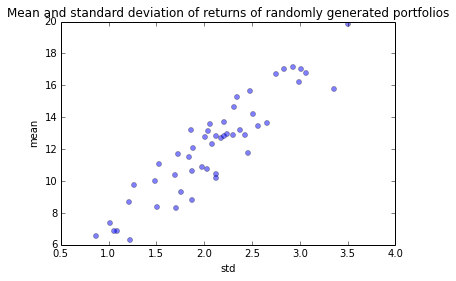

In [564]:
plt.plot(stds, means, 'o', markersize=5, alpha=0.5)
plt.xlabel('std')
plt.ylabel('mean')
plt.title('Mean and standard deviation of returns of randomly generated portfolios')


## Finding the efficient frontier

We are essentially trying to solve:

$\newcommand{\ones}{{\bf 1}}\begin{array}{ll}\mbox{minimize}   & -\bar p^T x + \mu x^T S x \\\mbox{subject to} & \ones^T x = 1, \quad x \succeq 0\end{array}$

Minimize alpha \* Risk - Returns . $\alpha$ controlls how risk averse we want to be. $\alpha=0$ indicates we don't care about risk at all. 


Resources:
http://blog.quantopian.com/markowitz-portfolio-optimization-2/
http://cvxopt.org/userguide/coneprog.html#quadratic-programming
http://cvxopt.org/examples/book/portfolio.html


In [629]:
def optimal_portfolio(returns):
    n = len(returns)
    pbar = opt.matrix(np.mean(returns, axis=1))
    
    N = 10
    mus = [5.8**(5.0 * t/N - 1.0) for t in range(N)]
    mus = [0.0]+mus
    #mus = [t/1.22 for t in range(N)]
    #mus = [0.05+(0.05*t) for t in range(150)]
    # Convert to cvxopt matrices
    S = opt.matrix(np.cov(returns))
    #returns = np.asmatrix(returns)   
    returns = opt.matrix(returns)
    # Create constraint matrices
    G = -opt.matrix(np.eye(n))   # negative n x n identity matrix
    h = opt.matrix(0.0, (n ,1))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)
    print "S, Covariance: ", S.size, S
    print "Returns: ", returns.size
    print "pbar: ", pbar.size, pbar.T
    print "G: ", G.size
    print "h: ", h.size
    print "A: ", A.size
    print "b: ", b.size
    
    # Calculate efficient frontier weights using quadratic programming
    portfolios=[]
    for mu in mus:
        try:
            result = solvers.qp(mu*S, -pbar, G, h, A, b)['x'] 
            #Result is presumably the weights for a given mu
            portfolios.append(result)
        except :
            print "BAD MU ", mu
            pass
    ## CALCULATE RISKS AND RETURNS FOR FRONTIER
    returns = [blas.dot(pbar, x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x, S*x)) for x in portfolios]
    
    ## CALCULATE THE 2ND DEGREE POLYNOMIAL OF THE FRONTIER CURVE
    m1 = np.polyfit(returns, risks, 2)
    gradients = np.gradient(returns)
    print "mu, grad, r, risk, portfolios"
    for p,mu,r,grad, risk in zip(portfolios,mus,returns,gradients,risks):
        s = get_market_weights(p)
        print "%0.2f %0.2f %0.2f %0.2f -> %s" % (mu,grad, r, risk,s)
    print "POLYNOMIAL ", m1
    #mu_star = np.sqrt(m1[2] / m1[0])
    #This doesnt work because the slope values are negative
    #No negatively sloped lines will be tangential to the curves we get
    # CALCULATE THE OPTIMAL PORTFOLIO
    wt = np.zeros(n)
    try:
        mu_star = 10.0
        wt = solvers.qp(opt.matrix(mu_star * S), -pbar, G, h, A, b)['x']
        print "TANGENTIAL WT"
        print get_market_weights(np.array(wt))
    except:
        print "NOT ABLE TO CALCULATE OPTIMUM WEIGHTS"
    return np.asarray(wt), returns, risks

In [630]:
weights, returns, risks = optimal_portfolio(dt)

S, Covariance:  (15, 15) [ 1.81e-02 -2.08e-03  9.78e-03  1.14e-03 -5.15e-04  1.83e-03  8.34e-03 ... ]
[-2.08e-03  4.44e+00 -3.16e-01  8.20e-02 -5.12e-03 -2.74e-01 -3.52e-02 ... ]
[ 9.78e-03 -3.16e-01  7.80e-01 -1.05e-02  1.33e-01  1.19e-01  4.34e-02 ... ]
[ 1.14e-03  8.20e-02 -1.05e-02  3.32e-01  9.73e-02 -2.32e-03 -1.13e-02 ... ]
[-5.15e-04 -5.12e-03  1.33e-01  9.73e-02  4.03e-01  3.52e-02 -1.26e-02 ... ]
[ 1.83e-03 -2.74e-01  1.19e-01 -2.32e-03  3.52e-02  1.03e-01  1.61e-02 ... ]
[ 8.34e-03 -3.52e-02  4.34e-02 -1.13e-02 -1.26e-02  1.61e-02  1.27e-01 ... ]
[-2.54e-02 -3.85e-02  3.08e-01  8.66e-01  6.94e-01  3.66e-01 -1.41e-01 ... ]
[ 1.74e-01  1.06e+01 -1.27e+00 -2.35e-01 -9.15e-01 -3.82e-02  3.72e-01 ... ]
[-2.15e-02  1.49e+01 -2.41e+00  4.13e-01 -3.08e-01 -1.77e+00 -3.08e-01 ... ]
[-7.59e-06  1.60e-03 -3.45e-04  8.62e-06 -6.31e-05 -3.41e-04 -7.17e-05 ... ]
[-3.75e-04 -6.08e-02  5.19e-02  3.78e-02  9.05e-02  2.47e-02 -7.44e-03 ... ]
[ 1.60e-03 -2.79e-01  1.16e-01 -4.61e-04  3.96e-02 

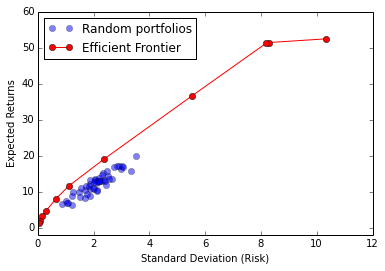

In [624]:
plt.plot(stds, means, 'o',alpha=0.5,label="Random portfolios")
plt.ylabel('Expected Returns')
plt.xlabel('Standard Deviation (Risk)')
plt.plot(risks, returns, marker='o',color='r',label="Efficient Frontier")
plt.ylim(ymin=-2)
plt.legend(loc='best')
plt.savefig("15mkts.pdf")

In [610]:
def get_market_weights(p):
    #s = np.array(p.T)[0]
    s = p
    df = pd.DataFrame(zip(s,instances),columns=['wt','market'])
    df = df[df['wt']>0.01]
    outlist = []
    outstring = ''
    for index, row in df.iterrows():
        outlist.append( (simple_mkt_string(row['market']), row['wt'] ) )
        outstring = outstring + simple_mkt_string(row['market']) +": "+ str(row['wt']) +", "
    return outstring

def simple_mkt_string(i):
    return i['AZ']+'-'+i['type']

In [611]:
get_market_weights(np.arange(0,len(instances)))

'b-g2.2xlarge: 1, a-c3.xlarge: 2, a-r3.large: 3, e-r3.large: 4, b-m3.medium: 5, e-c3.xlarge: 6, a-d2.8xlarge: 7, b-d2.8xlarge: 8, e-d2.8xlarge: 9, e-m3.medium: 10, b-r3.large: 11, a-m3.medium: 12, e-g2.2xlarge: 13, a-g2.2xlarge: 14, '

## Picking the right alpha

A question that persists is how to map user requirements to alpha. How to pick the right alpha?
If you notice, the last step in the optimization is trying to find the portfolio that is tangential to the optimal frontier. The mu_star variable is the slope of this tangent. Thus, mu_star gives an indication for how much we value risk. *Probably a better term for this*

A high mu_star indicates a steep slope, which means that the user is willing to take only a small amount of risk for higher rewards. Where will such a line with a large slope be tangential to the efficient frontier? At low-risk values ofcourse! Similarly, a low sloping tangent will meet the frontier curve towards the right, where the risk (and rewards) are high.

Thus, the slope parameter is a good metric to capture risk averseness, and may even match resilency of applications. Highly resilient applications have high risk tolerance => lower sloped tangents => pick high risk/reward points on the right of the curve. Such points have fewer number of markets in their portfolio, as we can see from the output. 

Applications not resilient will tend to have higher mu, and larger number of markets.


# END

In [12]:
def my_covariance(x,y):
    """
    This yields similiar results to
    pd.Series(x).cov(pd.Series(y)) """
    xbar = x.mean()
    ybar = y.mean()
    x = x-xbar
    y = y-ybar
    n = min(x.shape[0], y.shape[0])
    x = x[:n-1]
    y = y[:n-1]
    cov = (x*y)
    cov = np.sum(cov)/(n-1)
    print cov
    return cov


In [114]:
print dt

[[ -6.4348  -6.435   -6.4349 ...,  -6.4347  -6.4351  -6.4354]
 [ -2.0676  -2.0679  -2.0676 ...,  -2.0679  -2.0654  -2.0679]
 [ -1.7281   0.      -1.733  ...,  -1.7318  -1.7313  -1.7331]
 [-54.64   -54.6365 -54.6361 ..., -54.6354 -54.6348 -54.6354]
 [  0.       0.       0.     ...,  -0.653   -0.653   -0.653 ]]


In [13]:
my_covariance(x,y)

-8.02333628098e-05


-8.0233362809846391e-05

In [14]:
pd.Series(x).cov(pd.Series(y))

-8.0003161504696132e-05

In [16]:

d0=data[0]
d1=data[1]
print d0

({'OS': 'Linux', 'region': 'us-east-1', 'AZ': 'a', 'type': 'g2.2xlarge'}, 0.65, array([[  1.42611080e+09,   6.52000000e-02],
       [  1.42611117e+09,   6.50000000e-02],
       [  1.42611153e+09,   6.51000000e-02],
       ..., 
       [  1.44108320e+09,   1.25300000e-01],
       [  1.44108337e+09,   1.18500000e-01],
       [  1.44108353e+09,   1.14200000e-01]]))


In [17]:
s0 = pd.Series(d0[2][:,1], index=d0[2][:,0])